# Prediction of COVID-19 Cases using Supervised Machine Learning based on Patients' Symptoms

<b>Subject:</b> WQD7006 Machine Learning for Data Science
<br><b>Student Name:</b> Muhamad Haziq Bin Fuad
<br><b>Student Matric Number:</b> S2031779

## Introduction

The Israeli Ministry of Health publicly released data of all individuals who were tested for SARS-CoV-2 via RT-PCR assay of a nasopharyngeal swab. During the first months of the COVID-19 pandemic in Israel, all diagnostic laboratory tests for COVID-19 were performed according to criteria determined by the Israeli Ministry of Health. While subject to change, the criteria implemented during the study period included the presence and severity of clinical symptoms, possible exposure to individuals confirmed to have COVID-19, certain geographical areas, and the risk of complications if infected. Except for a small minority who was tested under surveys among healthcare workers, all the individuals tested had indications for testing. In addition, all negative and positive COVID-19 cases this dataset were confirmed via RT-PCR assay.

In this project, we propose a machine learning model that predicts a positive COVID-19 infection in a RT-PCR test through several basic and clinical information of the patients. The model was trained on data of all individuals in Israel tested for COVID-19 during the first months of the pandemic. Thus, our model can be implemented globally for effective screening and prioritization of testing for the virus in the general population.

## Objective

1) To classify whether individuals with certain health symptoms are infected with COVID-19 using several classification methods.
<br>2) To evaluate the performance of different supervised learning classification models

## Coding

### Importing packages

In [1]:
# data extraction, manipulation, cleaning & feature engineering
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# encoding relevant features
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import tree

# model performance evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### Step 1: Import data

In [2]:
# importing dataset (in csv file format) and assigned it into 'df' variable by specifying the features types

df = pd.read_csv("covid19_data.csv", dtype={'cough':str,'fever':str, 'sore_throat':str, 'shortness_of_breath':str,
                                            'head_ache':str}, parse_dates=['test_date'])

In [3]:
# general preview of the imported dataset (first 5 rows of the data)

df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


In [4]:
df.shape

(278848, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            278848 non-null  datetime64[ns]
 1   cough                278848 non-null  object        
 2   fever                278848 non-null  object        
 3   sore_throat          278848 non-null  object        
 4   shortness_of_breath  278848 non-null  object        
 5   head_ache            278848 non-null  object        
 6   corona_result        278848 non-null  object        
 7   age_60_and_above     278848 non-null  object        
 8   gender               278848 non-null  object        
 9   test_indication      278848 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 21.3+ MB


In [6]:
# column age will be dropped in this model since half of the data points are considered irrelevant and pose no meaning to the model

###  Step 2: Data Cleaning & Preprocessing

In [7]:
#checking for missing values in the dataframe

missing_values = df.isnull().sum() # missing values
percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value in %

value = {'missing_values ':missing_values, 'percent_missing %':percent_missing}
missing_frame=pd.DataFrame(value)
missing_frame

,missing_values,percent_missing %
test_date,0,0.0
cough,0,0.0
fever,0,0.0
sore_throat,0,0.0
shortness_of_breath,0,0.0
head_ache,0,0.0
corona_result,0,0.0
age_60_and_above,0,0.0
gender,0,0.0
test_indication,0,0.0


In [8]:
# checking for unique data points for each features

for i in range(1, 10):

    print(df.iloc[:,i].value_counts()/df.iloc[:,i].count()*100, '\n')

0       84.765894
1       15.143734
None     0.090372
Name: cough, dtype: float64 

0       92.108963
1        7.800666
None     0.090372
Name: fever, dtype: float64 

0       99.308943
1        0.690699
None     0.000359
Name: sore_throat, dtype: float64 

0       99.434100
1        0.565541
None     0.000359
Name: shortness_of_breath, dtype: float64 

0       99.133937
1        0.865705
None     0.000359
Name: head_ache, dtype: float64 

negative    93.322168
positive     5.282089
other        1.395742
Name: corona_result, dtype: float64 

None    45.659284
No      45.079398
Yes      9.261318
Name: age_60_and_above, dtype: float64 

female    46.677043
male      46.307307
None       7.015650
Name: gender, dtype: float64 

Other                     87.051368
Abroad                     9.133291
Contact with confirmed     3.815340
Name: test_indication, dtype: float64 



In [9]:
#filtered out irrelevant health conditions & symptoms i.e. None, other & etc.

filtered_df = df[ (df['cough'] != 'None') & (df['fever'] != 'None') & (df['sore_throat'] != 'None') &
                 (df['shortness_of_breath'] != 'None') & (df['head_ache'] != 'None') & 
                 (df['corona_result'] != 'other') & (df['gender'] != 'None')]

### Step 3: Data Preprocessing & Feature Engineering

In [10]:
# pre-processing - converting data types to compatible formats i.e. strings to datetime and integer

filtered_df[["test_date"]] = filtered_df[["test_date"]].apply(pd.to_datetime)
filtered_df[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']] = filtered_df[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].astype(int)

D:\Softwares\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
for i in range(1, 10):

    print(filtered_df.iloc[:,i].value_counts() / filtered_df.iloc[:,i].count()*100, '\n')

0    84.725503
1    15.274497
Name: cough, dtype: float64 

0    92.23446
1     7.76554
Name: fever, dtype: float64 

0    99.414866
1     0.585134
Name: sore_throat, dtype: float64 

0    99.578359
1     0.421641
Name: shortness_of_breath, dtype: float64 

0    99.177449
1     0.822551
Name: head_ache, dtype: float64 

negative    94.707198
positive     5.292802
Name: corona_result, dtype: float64 

None    46.691021
No      44.038753
Yes      9.270225
Name: age_60_and_above, dtype: float64 

female    50.226466
male      49.773534
Name: gender, dtype: float64 

Other                     87.130967
Abroad                     9.116902
Contact with confirmed     3.752132
Name: test_indication, dtype: float64 



In [12]:
# dropping column age_60_and_above due to almost half of the data are irrelevant i.e. None, no specified age for the individual

filtered_df = filtered_df.drop(['age_60_and_above'], axis=1)

# drop date column

filtered_df = filtered_df.drop(['test_date'], axis=1)

In [13]:
# encoding categorical variables for modeling purposes

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

enc_df = filtered_df.copy()

enc_df['corona_result'] = enc.fit_transform(enc_df['corona_result'])
enc_df['gender'] = enc.fit_transform(enc_df['gender'])
enc_df['test_indication'] = enc.fit_transform(enc_df['test_indication'])

In [14]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255668 entries, 0 to 265120
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   cough                255668 non-null  int32
 1   fever                255668 non-null  int32
 2   sore_throat          255668 non-null  int32
 3   shortness_of_breath  255668 non-null  int32
 4   head_ache            255668 non-null  int32
 5   corona_result        255668 non-null  int32
 6   gender               255668 non-null  int32
 7   test_indication      255668 non-null  int32
dtypes: int32(8)
memory usage: 9.8 MB


### Step 4: Basic EDA & Visualization

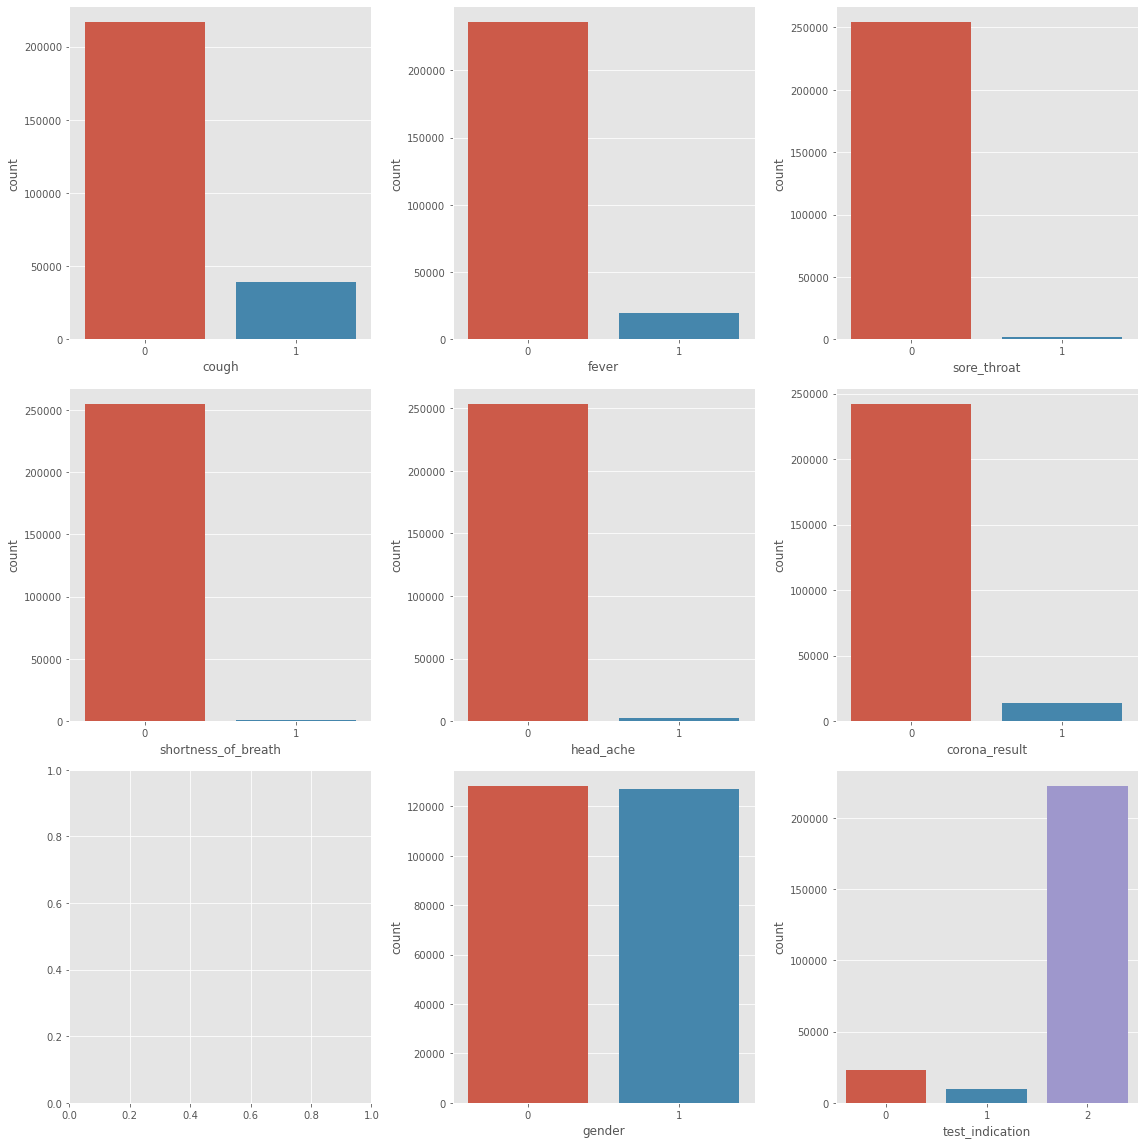

In [15]:
# plotting charts to visualize generic information of the features and target variable

plt.style.use('ggplot')

fig, ax = plt.subplots(3, 3, figsize=(16,16))
sns.countplot('cough', data=enc_df, ax=ax[0][0])
sns.countplot('fever', data=enc_df, ax=ax[0][1])
sns.countplot('sore_throat', data=enc_df, ax=ax[0][2])
sns.countplot('shortness_of_breath', data=enc_df, ax=ax[1][0])
sns.countplot('head_ache', data=enc_df, ax=ax[1][1])
sns.countplot('corona_result', data=enc_df, ax=ax[1][2])
sns.countplot('gender', data=enc_df, ax=ax[2][1])
sns.countplot('test_indication', data=enc_df, ax=ax[2][2])
plt.tight_layout()

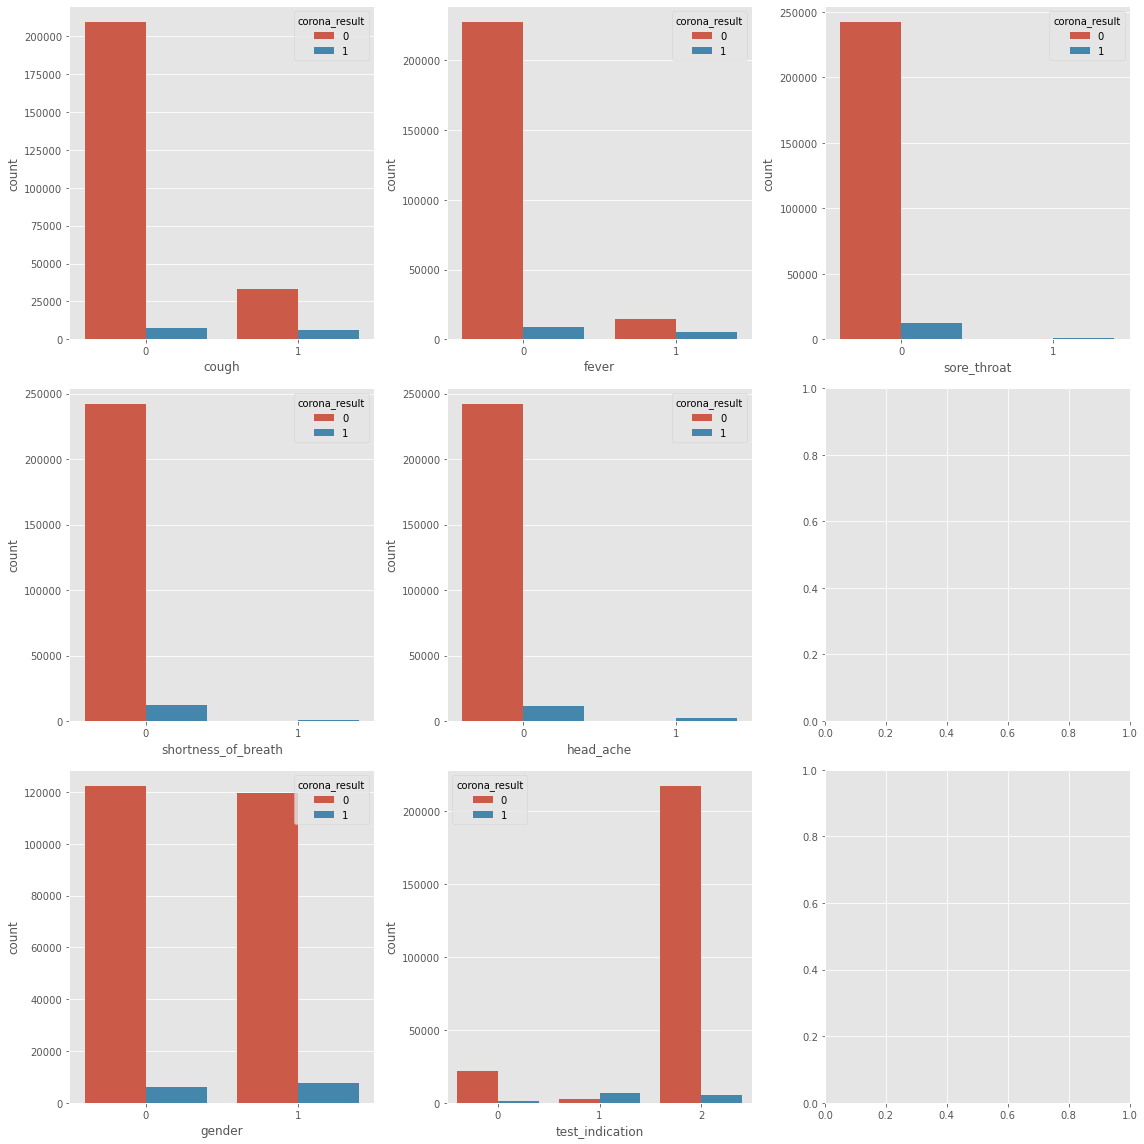

In [16]:
# plotting charts to visualize relationship between features and target variables

fig, ax = plt.subplots(3, 3, figsize=(16,16))
sns.countplot('cough', data=enc_df, ax=ax[0][0], hue='corona_result')
sns.countplot('fever', data=enc_df, ax=ax[0][1], hue='corona_result')
sns.countplot('sore_throat', data=enc_df, ax=ax[0][2], hue='corona_result')
sns.countplot('shortness_of_breath', data=enc_df, ax=ax[1][0], hue='corona_result')
sns.countplot('head_ache', data=enc_df, ax=ax[1][1], hue='corona_result')
sns.countplot('gender', data=enc_df, ax=ax[2][0], hue='corona_result')
sns.countplot('test_indication', data=enc_df, ax=ax[2][1], hue='corona_result')
plt.tight_layout()

In [17]:
#feature correlation - observing relationship between different features and target variable (COVID-19 result)

corr = enc_df.corr()
corr.style.background_gradient(cmap='coolwarm',axis=None)

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,gender,test_indication
cough,1.000000,0.451896,0.105560,0.097546,0.114091,0.194106,0.030953,-0.569529
fever,0.451896,1.000000,0.118579,0.118703,0.164186,0.260399,0.035893,-0.343291
sore_throat,0.105560,0.118579,1.000000,0.204739,0.339929,0.293147,-0.005909,-0.072510
shortness_of_breath,0.097546,0.118703,0.204739,1.000000,0.222638,0.248565,0.004520,-0.056723
head_ache,0.114091,0.164186,0.339929,0.222638,1.000000,0.366278,0.002188,-0.083327
corona_result,0.194106,0.260399,0.293147,0.248565,0.366278,1.000000,0.026961,-0.197408
gender,0.030953,0.035893,-0.005909,0.004520,0.002188,0.026961,1.000000,-0.030257
test_indication,-0.569529,-0.343291,-0.072510,-0.056723,-0.083327,-0.197408,-0.030257,1.000000


As we can observe in the correlation heatmap generated above, there are few parameters that have low correlation level with the target variable. Due to time constraint, I will not be exploring the affects of certain features on the prediction and only focusing on tuning the model parameters to improve its performance.

### Step 5: Modeling

In [18]:
# define the target and feature variables

X = enc_df.loc[:, enc_df.columns != 'corona_result']
y = enc_df.loc[:, 'corona_result']

In [19]:
X.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,gender,test_indication
0,0,0,0,0,0,0,2
1,1,0,0,0,0,0,2
2,0,1,0,0,0,1,2
3,1,0,0,0,0,0,2
4,1,0,0,0,0,1,2


In [20]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: corona_result, dtype: int32

In [21]:
#Splitting dataset into training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#### Logistic Regression

In [22]:
#Fitting Logistic Regression model to the training set

lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predicting the corona result i.e. y_pred based on the testing datasets i.e. x_test

y_pred = lr.predict(X_test)

# observing the accuracy, sensitivity and specifity of the model

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

lr_acc = accuracy_score(y_test, y_pred)*100 #accuracy score
lr_sen = recall_score(y_test, y_pred)*100 #sensitivity score
lr_spe = TP/(TN+FP)*100 #specifity score
lr_pre = precision_score(y_test, y_pred)*100 #precision score
lr_f1 = f1_score(y_test, y_pred)*100 #f1 score

print('Accuracy=%.4f' % (lr_acc))
print('Sensitivity=%.4f' % (lr_sen))
print('Specifity=%.4f' % (lr_spe))
print('Precision=%.4f' % (lr_pre))
print('F1-Score=%.4f' % (lr_f1))

Accuracy=95.8619
Sensitivity=25.4526
Specifity=1.4533
Precision=92.5000
F1-Score=39.9205


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     48372
           1       0.93      0.25      0.40      2762

    accuracy                           0.96     51134
   macro avg       0.94      0.63      0.69     51134
weighted avg       0.96      0.96      0.95     51134



#### Naive Bayes

In [24]:
#Fitting Naive Bayes model to the training set

nb = GaussianNB()
nb.fit(X_train, y_train)

# Predicting the corona result i.e. y_pred based on the testing datasets i.e. x_test

y_pred = nb.predict(X_test)

# observing the accuracy, sensitivity and specifity of the model

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

nb_acc = accuracy_score(y_test, y_pred)*100 #accuracy score
nb_sen = recall_score(y_test, y_pred)*100 #sensitivity score
nb_spe = TP/(TN+FP)*100 #specifity score
nb_pre = precision_score(y_test, y_pred)*100 #precision score
nb_f1 = f1_score(y_test, y_pred)*100 #f1 score

print('Accuracy=%.4f' % (nb_acc))
print('Sensitivity=%.4f' % (nb_sen))
print('Specifity=%.4f' % (nb_spe))
print('Precision=%.4f' % (nb_pre))
print('F1-Score=%.4f' % (nb_f1))

Accuracy=94.7452
Sensitivity=26.5025
Specifity=1.5133
Precision=52.6998
F1-Score=35.2686


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     48372
           1       0.53      0.27      0.35      2762

    accuracy                           0.95     51134
   macro avg       0.74      0.63      0.66     51134
weighted avg       0.94      0.95      0.94     51134



#### Support Vector Machine

In [26]:
#Fitting Support Vector Machine model to the training set

svc = SVC()
svc.fit(X_train, y_train)

# Predicting the corona result i.e. y_pred based on the testing datasets i.e. x_test

y_pred = svc.predict(X_test)

# observing the accuracy, sensitivity and specifity of the model

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

svm_acc = accuracy_score(y_test, y_pred)*100 #accuracy score
svm_sen = recall_score(y_test, y_pred)*100 #sensitivity score
svm_spe = TP/(TN+FP)*100 #specifity score
svm_pre = precision_score(y_test, y_pred)*100 #precision score
svm_f1 = f1_score(y_test, y_pred)*100 #f1 score

print('Accuracy=%.4f' % (svm_acc))
print('Sensitivity=%.4f' % (svm_sen))
print('Specifity=%.4f' % (svm_spe))
print('Precision=%.4f' % (svm_pre))
print('F1-Score=%.4f' % (svm_f1))

Accuracy=96.9433
Sensitivity=54.8516
Specifity=3.1320
Precision=82.7417
F1-Score=65.9700


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     48372
           1       0.83      0.55      0.66      2762

    accuracy                           0.97     51134
   macro avg       0.90      0.77      0.82     51134
weighted avg       0.97      0.97      0.97     51134



#### Decision Tree

In [28]:
#Fitting Decision Tree model to the training set

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# Predicting the corona result i.e. y_pred based on the testing datasets i.e. x_test

y_pred = dt.predict(X_test)

# observing the accuracy, sensitivity and specifity of the model

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

dt_acc = accuracy_score(y_test, y_pred)*100 #accuracy score
dt_sen = recall_score(y_test, y_pred)*100 #sensitivity score
dt_spe = TP/(TN+FP)*100 #specifity score
dt_pre = precision_score(y_test, y_pred)*100 #precision score
dt_f1 = f1_score(y_test, y_pred)*100 #f1 score

print('Accuracy=%.4f' % (dt_acc))
print('Sensitivity=%.4f' % (dt_sen))
print('Specifity=%.4f' % (dt_spe))
print('Precision=%.4f' % (dt_pre))
print('F1-Score=%.4f' % (dt_f1))

Accuracy=96.9453
Sensitivity=59.2686
Specifity=3.3842
Precision=78.9296
F1-Score=67.7006


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     48372
           1       0.79      0.59      0.68      2762

    accuracy                           0.97     51134
   macro avg       0.88      0.79      0.83     51134
weighted avg       0.97      0.97      0.97     51134



#### Random Forest

In [30]:
#Fitting Random Forest model to the training set

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predicting the corona result i.e. y_pred based on the testing datasets i.e. x_test

y_pred = rf.predict(X_test)

# observing the accuracy, sensitivity and specifity of the model

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

rf_acc = accuracy_score(y_test, y_pred)*100 #accuracy score
rf_sen = recall_score(y_test, y_pred)*100 #sensitivity score
rf_spe = TP/(TN+FP)*100 #specifity score
rf_pre = precision_score(y_test, y_pred)*100 #precision score
rf_f1 = f1_score(y_test, y_pred)*100 #f1 score

print('Accuracy=%.4f' % (rf_acc))
print('Sensitivity=%.4f' % (rf_sen))
print('Specifity=%.4f' % (rf_spe))
print('Precision=%.4f' % (rf_pre))
print('F1-Score=%.4f' % (rf_f1))

Accuracy=96.9551
Sensitivity=59.4497
Specifity=3.3945
Precision=78.9803
F1-Score=67.8372


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     48372
           1       0.79      0.59      0.68      2762

    accuracy                           0.97     51134
   macro avg       0.88      0.79      0.83     51134
weighted avg       0.97      0.97      0.97     51134



#### K-Nearest Neighbors

In [32]:
#Fitting KNN model to the training set

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predicting the corona result i.e. y_pred based on the testing datasets i.e. x_test

y_pred = knn.predict(X_test)

# observing the accuracy, sensitivity and specifity of the model

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

knn_acc = accuracy_score(y_test, y_pred)*100 #accuracy score
knn_sen = recall_score(y_test, y_pred)*100 #sensitivity score
knn_spe = TP/(TN+FP)*100 #specifity score
knn_pre = precision_score(y_test, y_pred)*100 #precision score
knn_f1 = f1_score(y_test, y_pred)*100 #f1 score

print('Accuracy=%.4f' % (knn_acc))
print('Sensitivity=%.4f' % (knn_sen))
print('Specifity=%.4f' % (knn_spe))
print('Precision=%.4f' % (knn_pre))
print('F1-Score=%.4f' % (knn_f1))

Accuracy=96.6070
Sensitivity=61.8030
Specifity=3.5289
Precision=71.5124
F1-Score=66.3041


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     48372
           1       0.72      0.62      0.66      2762

    accuracy                           0.97     51134
   macro avg       0.85      0.80      0.82     51134
weighted avg       0.96      0.97      0.96     51134



#### Extreme Gradient Boosting

In [34]:
#Fitting XGB model to the training set

xgb = XGBClassifier(random_state =1)
xgb.fit(X_train, y_train)

# Predicting the corona result i.e. y_pred based on the testing datasets i.e. x_test

y_pred = xgb.predict(X_test)

# observing the accuracy, sensitivity and specifity of the model

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

xgb_acc = accuracy_score(y_test, y_pred)*100 #accuracy score
xgb_sen = recall_score(y_test, y_pred)*100 #sensitivity score
xgb_spe = TP/(TN+FP)*100 #specifity score
xgb_pre = precision_score(y_test, y_pred)*100 #precision score
xgb_f1 = f1_score(y_test, y_pred)*100 #f1 score

print('Accuracy=%.4f' % (xgb_acc))
print('Sensitivity=%.4f' % (xgb_sen))
print('Specifity=%.4f' % (xgb_spe))
print('Precision=%.4f' % (xgb_pre))
print('F1-Score=%.4f' % (xgb_f1))

D:\Softwares\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:08:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy=96.9375
Sensitivity=54.7429
Specifity=3.1258
Precision=82.7133
F1-Score=65.8824


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     48372
           1       0.83      0.55      0.66      2762

    accuracy                           0.97     51134
   macro avg       0.90      0.77      0.82     51134
weighted avg       0.97      0.97      0.97     51134



### Step 6: Performance Evaluation

In [36]:
# generate a table showing performance of each models i.e. accuracy

models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'K Nearest Neighbors', 'Logistic Regression', 'Random Forest', 'Naive Bayes',   
              'Decision Tree', 'Extreme Gradient Boosting'],
    'Accuracy (%)': [svm_acc, knn_acc, lr_acc, rf_acc, nb_acc, dt_acc, xgb_acc],
    'Sensitivity (%)': [svm_sen, knn_sen, lr_sen, rf_sen, nb_sen, dt_sen, xgb_sen],
    'Specifity (%)': [svm_spe, knn_spe, lr_spe, rf_spe, nb_spe, dt_spe, xgb_spe],
    'Precision (%)': [svm_pre, knn_pre, lr_pre, rf_pre, nb_pre, dt_pre, xgb_pre],
    'F1-Score (%)': [svm_f1, knn_f1, lr_f1, rf_f1, nb_f1, dt_f1, xgb_f1]})
models.sort_values(by='Accuracy (%)', ascending=False).reset_index(drop=True)

,Model,Accuracy (%),Sensitivity (%),Specifity (%),Precision (%),F1-Score (%)
0,Random Forest,96.955059,59.449674,3.394526,78.980279,67.837224
1,Decision Tree,96.945281,59.268646,3.384189,78.929605,67.700579
2,Support Vector Machines,96.943325,54.851557,3.131977,82.741671,65.969954
3,Extreme Gradient Boosting,96.937458,54.742940,3.125775,82.713348,65.882353
4,K Nearest Neighbors,96.606954,61.803041,3.528901,71.512359,66.304137
5,Logistic Regression,95.861853,25.452571,1.453320,92.500000,39.920500
6,Naive Bayes,94.745179,26.502534,1.513272,52.699784,35.268610


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     48372
           1       0.83      0.55      0.66      2762

    accuracy                           0.97     51134
   macro avg       0.90      0.77      0.82     51134
weighted avg       0.97      0.97      0.97     51134



In [38]:
# choosing the final classifier model with tuned parameters

classifier = RandomForestClassifier()

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [39]:
# evaluating final model performance using AUROC method
roc_auc_score(y_train, classifier.predict_proba(X_train)[:, 1])

0.9012501019005652

In [40]:
# performance of the final model, Random Forest

TP, FN, FP, TN = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)

print('Accuracy=%.4f' % (accuracy_score(y_test, y_pred)*100))
print('Sensitivity=%.4f' % (recall_score(y_test, y_pred)*100))
print('Specifity=%.4f' % (TP/(TN+FP)*100))
print('Precision=%.4f' % (precision_score(y_test, y_pred)*100))
print('F1-Score=%.4f' % (f1_score(y_test, y_pred)*100))

Accuracy=96.9551
Sensitivity=59.4497
Specifity=3.3945
Precision=78.9803
F1-Score=67.8372


In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     48372
           1       0.79      0.59      0.68      2762

    accuracy                           0.97     51134
   macro avg       0.88      0.79      0.83     51134
weighted avg       0.97      0.97      0.97     51134



Baseline: ROC AUC=0.5000
Logistic Regression: ROC AUC=0.8578
Naive Bayes: ROC AUC=0.8527
Decision Tree: ROC AUC=0.8971
Random Forest: ROC AUC=0.8971
K Nearest Neighbors: ROC AUC=0.8427
Extreme Gradient Boosting: ROC AUC=0.8971


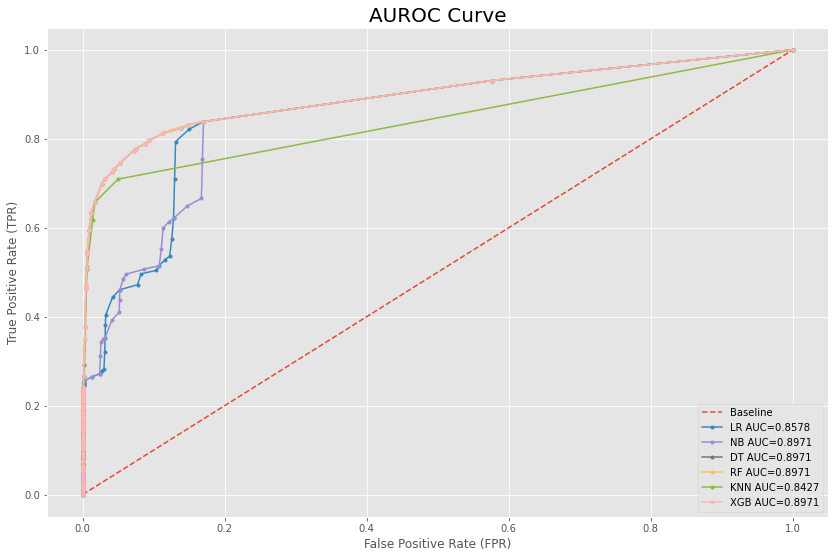

In [42]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = lr.predict_proba(X_test)
nb_probs = nb.predict_proba(X_test)
#svm_probs = svc.predict_proba(X_test)
dt_probs = dt.predict_proba(X_test)
rf_probs = classifier.predict_proba(X_test)
knn_probs = knn.predict_proba(X_test)
xgb_probs = xgb.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
nb_probs = nb_probs[:, 1]
#svm_probs = svm_probs[:, 1]
dt_probs = dt_probs[:, 1]
rf_probs = rf_probs[:, 1]
knn_probs = knn_probs[:, 1]
xgb_probs = xgb_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
#svm_auc = roc_auc_score(y_test, svm_probs)
dt_auc = roc_auc_score(y_test, dt_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# summarize scores
print('Baseline: ROC AUC=%.4f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.4f' % (lr_auc))
print('Naive Bayes: ROC AUC=%.4f' % (nb_auc))
#print('Support Vector Machine: ROC AUC=%.4f' % (svm_auc))
print('Decision Tree: ROC AUC=%.4f' % (dt_auc))
print('Random Forest: ROC AUC=%.4f' % (rf_auc))
print('K Nearest Neighbors: ROC AUC=%.4f' % (knn_auc))
print('Extreme Gradient Boosting: ROC AUC=%.4f' % (xgb_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
#svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

# plot the roc curve for the model
plt.figure(figsize=(14, 9))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LR AUC=%.4f' % (lr_auc))
plt.plot(nb_fpr, nb_tpr, marker='.', label='NB AUC=%.4f' % (rf_auc))
#plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
plt.plot(dt_fpr, dt_tpr, marker='.', label='DT AUC=%.4f' % (dt_auc))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC=%.4f' % (rf_auc))
plt.plot(knn_fpr, knn_tpr, marker='.', label='KNN AUC=%.4f' % (knn_auc))
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB AUC=%.4f' % (xgb_auc))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('AUROC Curve', size=20)
plt.legend()
plt.show()